##### XGB-Stepregression   
##20220409sym编写 
### 简介：  
使用逐步回归的方法提取最重要的特征相互作用
### 更新记录：  
V2，20221221sym更新，  
V2.1,20240117sym更新，加入yrealtestpred，假如要预测完全数据外的情况，用这个程序
V2.2，20240408sym更改，加入pred的std，并可以任意指定全集中的测试集，根据化学假的需求

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os
from pathlib import Path
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())


In [2]:
# 参数
# ======== System Setup ========
Version = 'V2.2sym'
EPOCH = 160
CORE_NUM = 32
# 确保EPOCH*REPEAT_ROUND是CORE_NUM的整数倍
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 43
F_N = 62
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_True_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
RECORD_NAME = 'Record_Stepreg_'+Version+'_'+c_time+'.txt'

X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
#是否设定第一特征
KNOW_inifeat=False
inifeat=[37]
# 记得减一
#F_N-1为全部特征都筛选
Stepfeatnum=5

# List of test set indices provided by the user
test_indices = [5,9,23,35]  # 对应是Full的matrix是刚刚好（有title的特征和标签值的Full）
test_indices = [i - 2 for i in test_indices]
test_mask = np.zeros(len(y), dtype=bool)
test_mask[test_indices] = True
X_train = X[~test_mask]
y_train = y[~test_mask]
Xrealtest = X[test_mask]
yrealtest = y[test_mask]
X=X_train
y=y_train


In [3]:
len(y)

39

In [4]:
yrealtest

array([1.73, 2.56, 4.4 , 2.34])

In [5]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [6]:
DIR = 'Stepreg-XGB_'+Version+'_'+c_time
os.mkdir(DIR)
RECORD_NAME = Path('.', DIR, RECORD_NAME)
f1 = open(RECORD_NAME, 'w')
f1.write('Record of XGB-Stepregression '+Version+'\n\n')
f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')
f1.write('Inputfiles are: '+INPUT_X+'+'+INPUT_Y+'+'+INPUT_TITLE+'+'+'\n\n\n')
f1.write('EPOCH= '+str(EPOCH)+' CORENUM= '+str(CORE_NUM)+INPUT_X+' splitratio= '+str(round(TRAIN_TEST_SPLIT,3))+'\n\n\n')
f1.write('test list see Feature matrix '+str(test_indices)+'\n\n\n')

save_nameX = 'Feature_X_train_'+str(len(y))+'_'+str(F_N)+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, X_train, fmt='%s', delimiter=',')
save_nameX = 'Feature_X_realtest_'+str(len(yrealtest))+'_'+str(F_N)+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, Xrealtest, fmt='%s', delimiter=',')
save_nameX = 'Value_y_train_'+str(len(y))+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, y_train, fmt='%s', delimiter=',')
save_nameX = 'Value_y_realtest_'+str(len(yrealtest))+'_'+c_time+'.csv'
save_nameX = Path('.', DIR, save_nameX)
np.savetxt(save_nameX, yrealtest, fmt='%s', delimiter=',')

In [7]:
clf = XGBRegressor(n_estimators=350, learning_rate=0.03, max_depth=8, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-3), reg_lambda=np.exp(-3), gamma=np.exp(-5), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []

In [8]:
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
#     mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     shap_values = shap.TreeExplainer(clf_new).shap_values(X)
#     s = np.mean(clf_new.predict(X))-np.mean(y_train)
#     s2 = np.mean(clf_new.predict(X))-np.mean(y)
#     print(np.sum(shap_values), s, s2)
#     # f_i = clf_new.feature_importances_
#      temp = [mse, mae, r2, shap_values, s, s2]
    temp = [mse]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')
def flatten(li):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in li), [])


In [9]:
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()
    mse_list=[]
#     mae_list=[]
#     r2_list=[]
#     shap_m = np.zeros((S_N, F_Ntemp))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
#         mae = temp[1]
#         r2 = temp[2]
        mse_list.append(mse)
#         mae_list.append(mae)
#         r2_list.append(r2)

    mse1=np.mean(mse_list)
#     mae1=np.mean(mae_list)
#     r21=np.mean(r2_list)
#     temp = [mse1, mae1, r21]
    temp = [mse1]
    return temp

Round 0
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 1
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 2
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 3
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 4
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 5
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 6
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 7
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 8
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 9
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 10
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 11
Round 1 Begin:
Round 3

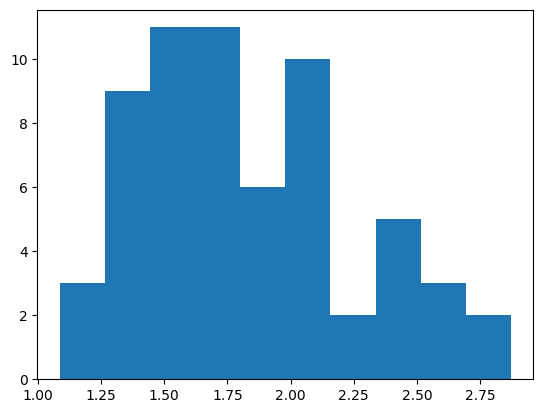

In [10]:
#在这里mse越小越好
if KNOW_inifeat == False:
    perflist1=[]
    for j in range (F_N):  
        print('Round',j)
        inifeat=title[j]
        inifeatindex=np.where(title==inifeat)[0][0]
        featlist=[]
        featlist.append(inifeatindex)
        Xtemp=X[:,featlist]
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist1.append(perf[0])    
    inifeat=np.where(perflist1==np.min(perflist1))
    print(inifeat)
    print(np.min(perflist1))
    print(perflist1)
    print(np.argsort(perflist1))
    perflistt=np.argsort(perflist1)
    for _ in range(10):
        print(title[perflistt[_]])
#画分布图
    n, bins, patches = plt.hist(perflist1)
    plt.show()
else:
    print('Already given first feature is ',title[inifeat],inifeat)

In [11]:
title[inifeat]

array(['Asymmetry_Ratio'], dtype='<U48')

In [12]:
inifeatindex=np.where(title==title[inifeat])[0][0]
print('first feature is ',inifeatindex)
featlist=[]
bestfeatlist=[]
mseind=[]
mselist=[]
for i in range(Stepfeatnum):#for i in range(F_N-1):
    perflist=np.linspace(0,0,len(title))
    print('Now we have ', i+1, 'Features.Begin regression!')
    if i ==0:       
        featlist.append(inifeatindex)
        print(featlist)
        Xtemp=X[:,featlist]
        print(Xtemp[0])
        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
        perflist=perf[0]
        bestfeatlist=featlist
        print('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
        f1.write('Round 1_'+str(title[bestfeatlist])+'_'+str(perflist)+'\n')
    else:
        for j in range (F_N):     
            featlist=bestfeatlist.copy()
            print('j=',j)
            if j in bestfeatlist:
                print('Already selected feature!')
            else:                   
                featlist.append(j)
                print('featlist=',featlist)
                Xtemp=X[:,featlist]
                print(Xtemp[0])
                perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
                perflist[j]=perf[0]
                print('perflist=',perflist)  
        max2 = np.sort(perflist)[i]
        mseind = np.argsort(perflist)[i]
        print('This feature is',mseind)
        print('best performance is',max2)
        bestfeatlist.append(mseind)
        print('bestfeatlist=',bestfeatlist)
        print(('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n'))
        f1.write('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(max2,4))+'\n')
        mselist.append(max2)
        print(mselist)
f1.close()

first feature is  49
Now we have  1 Features.Begin regression!
[49]
[0.98673547]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
Round 1_['Asymmetry_Ratio']_1.0277884851929042

Now we have  2 Features.Begin regression!
j= 0
featlist= [49, 0]
[0.98673547 0.68425037]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 12
featlist= [49, 12]
[0.98673547 2.08342128]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 0.        

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 0.96789356 1.08712416 1.22580309 1.21924097 1.18721244
 1.34623633 0.99024247 1.11403004 1.23914308 0.99567674 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 23
featlist= [49, 23]
[ 0.98673547 -9.645     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 0.96789356 1.08712416 1.22580309 1.21924097 1.18721244
 1.34623633 0.99024247 1.11403004 1.23914308 0.99567674 0.79387288
 1.005075   1.3127338  1.05491413 1.12313176 1.2076937  1.05314114
 0.9080829  1.35896975 1.08113652 0.88296408 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 34
featlist= [49, 34]
[ 0.98673547 10.108     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 0.96789356 1.08712416 1.22580309 1.21924097 1.18721244
 1.34623633 0.99024247 1.11403004 1.23914308 0.99567674 0.79387288
 1.005075   1.3127338  1.05491413 1.12313176 1.2076937  1.05314114
 0.9080829  1.35896975 1.08113652 0.88296408 1.143996   0.94900238
 1.00135764 0.94376253 0.8785007  1.048759   0.71019412 1.20753803
 1.23856387 1.10576077 0.90421686 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 45
featlist= [49, 45]
[ 0.98673547 -0.1663    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.13352503 1.27371517 1.07968974 1.17432946
 1.17166492 0.96789356 1.08712416 1.22580309 1.21924097 1.18721244
 1.34623633 0.99024247 1.11403004 1.23914308 0.99567674 0.79387288
 1.005075   1.3127338  1.05491413 1.12313176 1.2076937  1.05314114
 0.9080829  1.35896975 1.08113652 0.88296408 1.143996   0.94900238
 1.00135764 0.94376253 0.8785007  1.048759   0.71019412 1.20753803
 1.23856387 1.10576077 0.90421686 0.94367237 1.00106393 0.87976927
 1.01901283 0.         1.01598346 0.9969407  1.16098583 1.07210244
 0.99720556 1.02367093 0.         0.         0.         0.
 0.         0.        ]
j= 56
featlist= [49, 56]
[ 0.98673547 79.060008  ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [1.03293914 1.01485968 1.14010355 1.08947293 1.16735642 1.11085921
 1.29260391 1.28817604 1.133525

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 4
featlist= [49, 40, 4]
[0.98673547 8.6738     0.63218063]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.     

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.87525577 0.80254293 0.96582284 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [49, 40, 15]
[ 0.98673547  8.6738     64.        ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.875

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.87525577 0.80254293 0.96582284 0.84261413 0.94514504 0.86730128
 0.93054215 0.82621554 0.80851301 0.80343939 0.89226455 0.7711072
 0.71356035 0.80010673 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 26
featlist= [49, 40, 26]
[  0.98673547   8.6738     -14.761     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.87525577 0.80254293 0.96582284 0.84261413 0.94514504 0.86730128
 0.93054215 0.82621554 0.80851301 0.80343939 0.89226455 0.7711072
 0.71356035 0.80010673 0.6913482  0.73805469 0.7977112  0.84784225
 0.81163109 0.88211622 0.82801994 0.66527997 0.98445742 0.94624759
 0.85157856 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 37
featlist= [49, 40, 37]
[ 0.98673547  8.6738     10.314     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.829960

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.87525577 0.80254293 0.96582284 0.84261413 0.94514504 0.86730128
 0.93054215 0.82621554 0.80851301 0.80343939 0.89226455 0.7711072
 0.71356035 0.80010673 0.6913482  0.73805469 0.7977112  0.84784225
 0.81163109 0.88211622 0.82801994 0.66527997 0.98445742 0.94624759
 0.85157856 0.97749145 0.77263349 0.8947536  0.         1.04851165
 0.81868614 0.89577631 0.74708716 0.95386548 1.05752826 0.77853884
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 48
featlist= [49, 40, 48]
[ 0.98673547  8.6738     25.        ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.8

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.05948776 0.87913366 0.82996004 0.78222192 0.82018907
 0.87525577 0.80254293 0.96582284 0.84261413 0.94514504 0.86730128
 0.93054215 0.82621554 0.80851301 0.80343939 0.89226455 0.7711072
 0.71356035 0.80010673 0.6913482  0.73805469 0.7977112  0.84784225
 0.81163109 0.88211622 0.82801994 0.66527997 0.98445742 0.94624759
 0.85157856 0.97749145 0.77263349 0.8947536  0.         1.04851165
 0.81868614 0.89577631 0.74708716 0.95386548 1.05752826 0.77853884
 0.79257777 0.         0.8738383  0.69087387 0.86799043 0.96288515
 0.96839733 0.8483901  0.80020858 0.8717571  0.7101914  0.
 0.         0.        ]
j= 59
featlist= [49, 40, 59]
[  0.98673547   8.6738     653.19966   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.87842645 0.70991237 0.92894278 0.80610227 0.81617061 0.6920634
 0.93384082 1.0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 7
featlist= [49, 40, 33, 7]
[9.86735468e-01 8.67380000e+00 1.22490000e+01 1.28650613e+03]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.         0.         0.      

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.75281297 0.84601344 0.63978359 0.76638721 0.8067002
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [49, 40, 33, 18]
[  0.98673547   8.6738      12.249      421.2322    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197 

Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.75281297 0.84601344 0.63978359 0.76638721 0.8067002
 0.73109375 0.66453345 0.72164546 0.67894298 0.78297437 0.59432003
 0.61402246 0.70118112 0.68225747 0.66336207 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 28
featlist= [49, 40, 33, 28]
[ 0.98673547  8.6738     12.249      23.843     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.7528129

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.75281297 0.84601344 0.63978359 0.76638721 0.8067002
 0.73109375 0.66453345 0.72164546 0.67894298 0.78297437 0.59432003
 0.61402246 0.70118112 0.68225747 0.66336207 0.70584888 0.62304118
 0.70210142 0.76369225 0.68017432 0.         0.78027354 0.82346934
 0.64572399 0.77874088 0.61833571 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 39
featlist= [49, 40, 33, 39]
[ 0.98673547  8.6738     12.249      11.114     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.75281297 0.84601344 0.63978359 0.76638721 0.8067002
 0.73109375 0.66453345 0.72164546 0.67894298 0.78297437 0.59432003
 0.61402246 0.70118112 0.68225747 0.66336207 0.70584888 0.62304118
 0.70210142 0.76369225 0.68017432 0.         0.78027354 0.82346934
 0.64572399 0.77874088 0.61833571 0.84661515 0.         0.90196361
 0.73616191 0.76846621 0.69475895 0.86776467 0.95554836 0.68787488
 0.74077737 0.         0.68916    0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 51
featlist= [49, 40, 33, 51]
[   0.98673547    8.6738       12.249      -136.0860338 ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793


Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.73759793
 0.6852504  0.75636604 0.70022758 0.7772197  0.76979993 0.68933303
 0.67815981 0.75281297 0.84601344 0.63978359 0.76638721 0.8067002
 0.73109375 0.66453345 0.72164546 0.67894298 0.78297437 0.59432003
 0.61402246 0.70118112 0.68225747 0.66336207 0.70584888 0.62304118
 0.70210142 0.76369225 0.68017432 0.         0.78027354 0.82346934
 0.64572399 0.77874088 0.61833571 0.84661515 0.         0.90196361
 0.73616191 0.76846621 0.69475895 0.86776467 0.95554836 0.68787488
 0.74077737 0.         0.68916    0.60252973 0.7507666  0.85450004
 0.85545049 0.80229131 0.69338406 0.77238079 0.67479975 0.82875854
 0.758887   0.        ]
j= 61
featlist= [49, 40, 33, 61]
[ 0.98673547  8.6738     12.249       7.33305   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.80088895 0.72968615 0.79493795 0.79360015 0.88234504 0.7

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 9
featlist= [49, 40, 33, 23, 9]
[  0.98673547   8.6738      12.249       -9.645      593.4       ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0

Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0.83166494 0.72112421
 0.68775347 0.71637614 0.82517387 0.69352849 0.74091515 0.79267261
 0.7542551  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [49, 40, 33, 23, 19]
[ 0.98673547  8.6738     12.249      -9.645       1.9065    ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0.83

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0.83166494 0.72112421
 0.68775347 0.71637614 0.82517387 0.69352849 0.74091515 0.79267261
 0.7542551  0.78310659 0.80427742 0.77923376 0.71400133 0.
 0.69050971 0.71786831 0.69160478 0.71957676 0.70733587 0.67348325
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [49, 40, 33, 23, 30]
[ 0.98673547  8.6738     12.249      -9.645      20.388     ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0.83166494 0.72112421
 0.68775347 0.71637614 0.82517387 0.69352849 0.74091515 0.79267261
 0.7542551  0.78310659 0.80427742 0.77923376 0.71400133 0.
 0.69050971 0.71786831 0.69160478 0.71957676 0.70733587 0.67348325
 0.7503913  0.74609947 0.68848136 0.         0.70356959 0.79242838
 0.68681619 0.79267121 0.72769271 0.75624686 0.         0.82314544
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 42
featlist= [49, 40, 33, 23, 42]
[ 0.98673547  8.6738     12.249      -9.645      -0.40124   ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.749241

Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 0.74924131 0.81244799 0.74093157 0.77579924 0.83166494 0.72112421
 0.68775347 0.71637614 0.82517387 0.69352849 0.74091515 0.79267261
 0.7542551  0.78310659 0.80427742 0.77923376 0.71400133 0.
 0.69050971 0.71786831 0.69160478 0.71957676 0.70733587 0.67348325
 0.7503913  0.74609947 0.68848136 0.         0.70356959 0.79242838
 0.68681619 0.79267121 0.72769271 0.75624686 0.         0.82314544
 0.84055024 0.74513797 0.66133015 0.72967021 0.83104009 0.68272975
 0.75735028 0.         0.64186439 0.68137662 0.68079184 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 53
featlist= [49, 40, 33, 23, 53]
[ 0.98673547  8.6738     12.249      -9.645      20.5124077 ]
Round 1 Begin:
Round 33 Begin:
Round 65 Begin:
Round 97 Begin:
Round 129 Begin:
perflist= [0.70478723 0.75921582 0.86043622 0.77771977 0.72388368 0.7162595
 

4


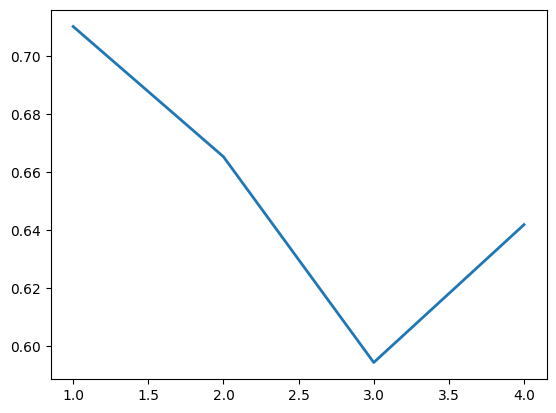

In [13]:
save_name1 = 'XGB-Stepregression_besttitles'+str(len(title[bestfeatlist]))+c_time+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,title[bestfeatlist], fmt='%s', delimiter=',', comments='!')
f.close()
import matplotlib.pyplot as plt
import numpy as np
# mselist.insert( 0, perf0)
# make data
x = np.linspace(1, Stepfeatnum-1,Stepfeatnum-1)
print(len(mselist))
y = mselist
# plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)
plt.show()

In [14]:
from sklearn import model_selection
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras,Xrealtest):
    r_l = []
    split_l=[]
    test_idx_m=[]
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            split_l.append(train_idx)
            test_idx_m.append(test_idx)
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()

    mse_list=[]
    mae_list=[]
    r2_list=[]
    results = r.get()
    shap_m = np.zeros((S_N-len(Xrealtest), len(X[0])))
    full_m=np.zeros((len(r_l),X.shape[0]))
    y_realtest_pred_list = []
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
        mae = temp[1]
        r2 = temp[2]
        shap_m += temp[3] 
        clf_new=results[1]
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)
        train_idx = split_l[i]
        test_idx = []
        for j in range(X.shape[0]):
            if j not in train_idx:
                test_idx.append(j)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_test = X[test_idx, :]
        y_test = y[test_idx]
        y_full_pred = clf_new.predict(X)
        y_realtest_pred=clf_new.predict(Xrealtest)
#         print(y_realtest_pred)
        y_realtest_pred_list.append(y_realtest_pred)
        
#         print(y_full_pred[0])
        full_m[i]=np.array(y_full_pred)
    mse1=np.mean(mse_list)
    mae1=np.mean(mae_list)
    r21=np.mean(r2_list)
    mse2=np.std(mse_list)
    shap_m2 = shap_m/len(r2_list)
    y_realtest_pred_std = np.std(y_realtest_pred_list, axis=0)
    temp = [mse1, mae1, r21,full_m,test_idx_m,mse2,shap_m2,y_realtest_pred,y_realtest_pred_std]
    return temp
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
    temp0 = [mse, mae, r2, shap_values]
    print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    return (temp0, clf_new)


# Create clf (sklean的API)
shap_m = np.zeros((S_N, len(X[0])))
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []
f_i = np.zeros((title.shape[0], 1))
max_r2 = -999.9

In [15]:
title[bestfeatlist]

array(['Asymmetry_Ratio', 'N27aliemin', 'N27espmax', 'N4espmin',
       'Total_number_of_peaks'], dtype='<U48')

In [16]:
# bestfeatlist=[8, 84, 89, 68, 109, 2]
# title[bestfeatlist]

X: (39, 62)    y: (39,)
[49]
1
Round 1 Begin:
   MSE: 1.24366   MAE: 1.04784   R^2: 0.57981
   MSE: 3.51997    MSE: 1.10454   MAE: 0.79361  MAE: 1.65225     MSE: 0.94450  R^2: -0.02180  R^2: -0.31787
 
  MAE: 0.86470   R^2: 0.66798
   MSE: 1.25664   MSE: 0.29359   MSE: 1.53671     MAE: 1.02761  MAE: 0.92260    R^2: 0.30591  MAE: 0.51448  R^2: -0.36981
 
  R^2: 0.63252
   MSE: 0.65100   MAE: 0.63243   R^2: 0.28685
   MSE: 0.46124   MAE: 0.63265   R^2: 0.42844
   MSE: 2.03447   MSE: 2.33872    MAE: 1.18408  MAE: 1.10737    R^2: -2.53239  R^2: -0.19212

   MSE: 1.26758   MSE: 0.83664    MAE: 0.69935  MAE: 0.98370    R^2: 0.15147  R^2: 0.52117

   MSE: 2.22655   MSE: 1.52123   MAE: 1.37188    MAE: 1.02801  R^2: 0.11773 
  R^2: -0.18532
   MSE: 2.61494   MAE: 1.31274   R^2: -0.22469
   MSE: 1.73082   MSE: 0.19433    MAE: 1.07272  MAE: 0.39458    R^2: 0.04719  R^2: 0.86603

   MSE: 0.46393   MAE: 0.62723   R^2: 0.82082
   MSE: 0.85267   MAE: 0.80106   R^2: 0.72932
   MSE: 2.50067   MAE: 1.40

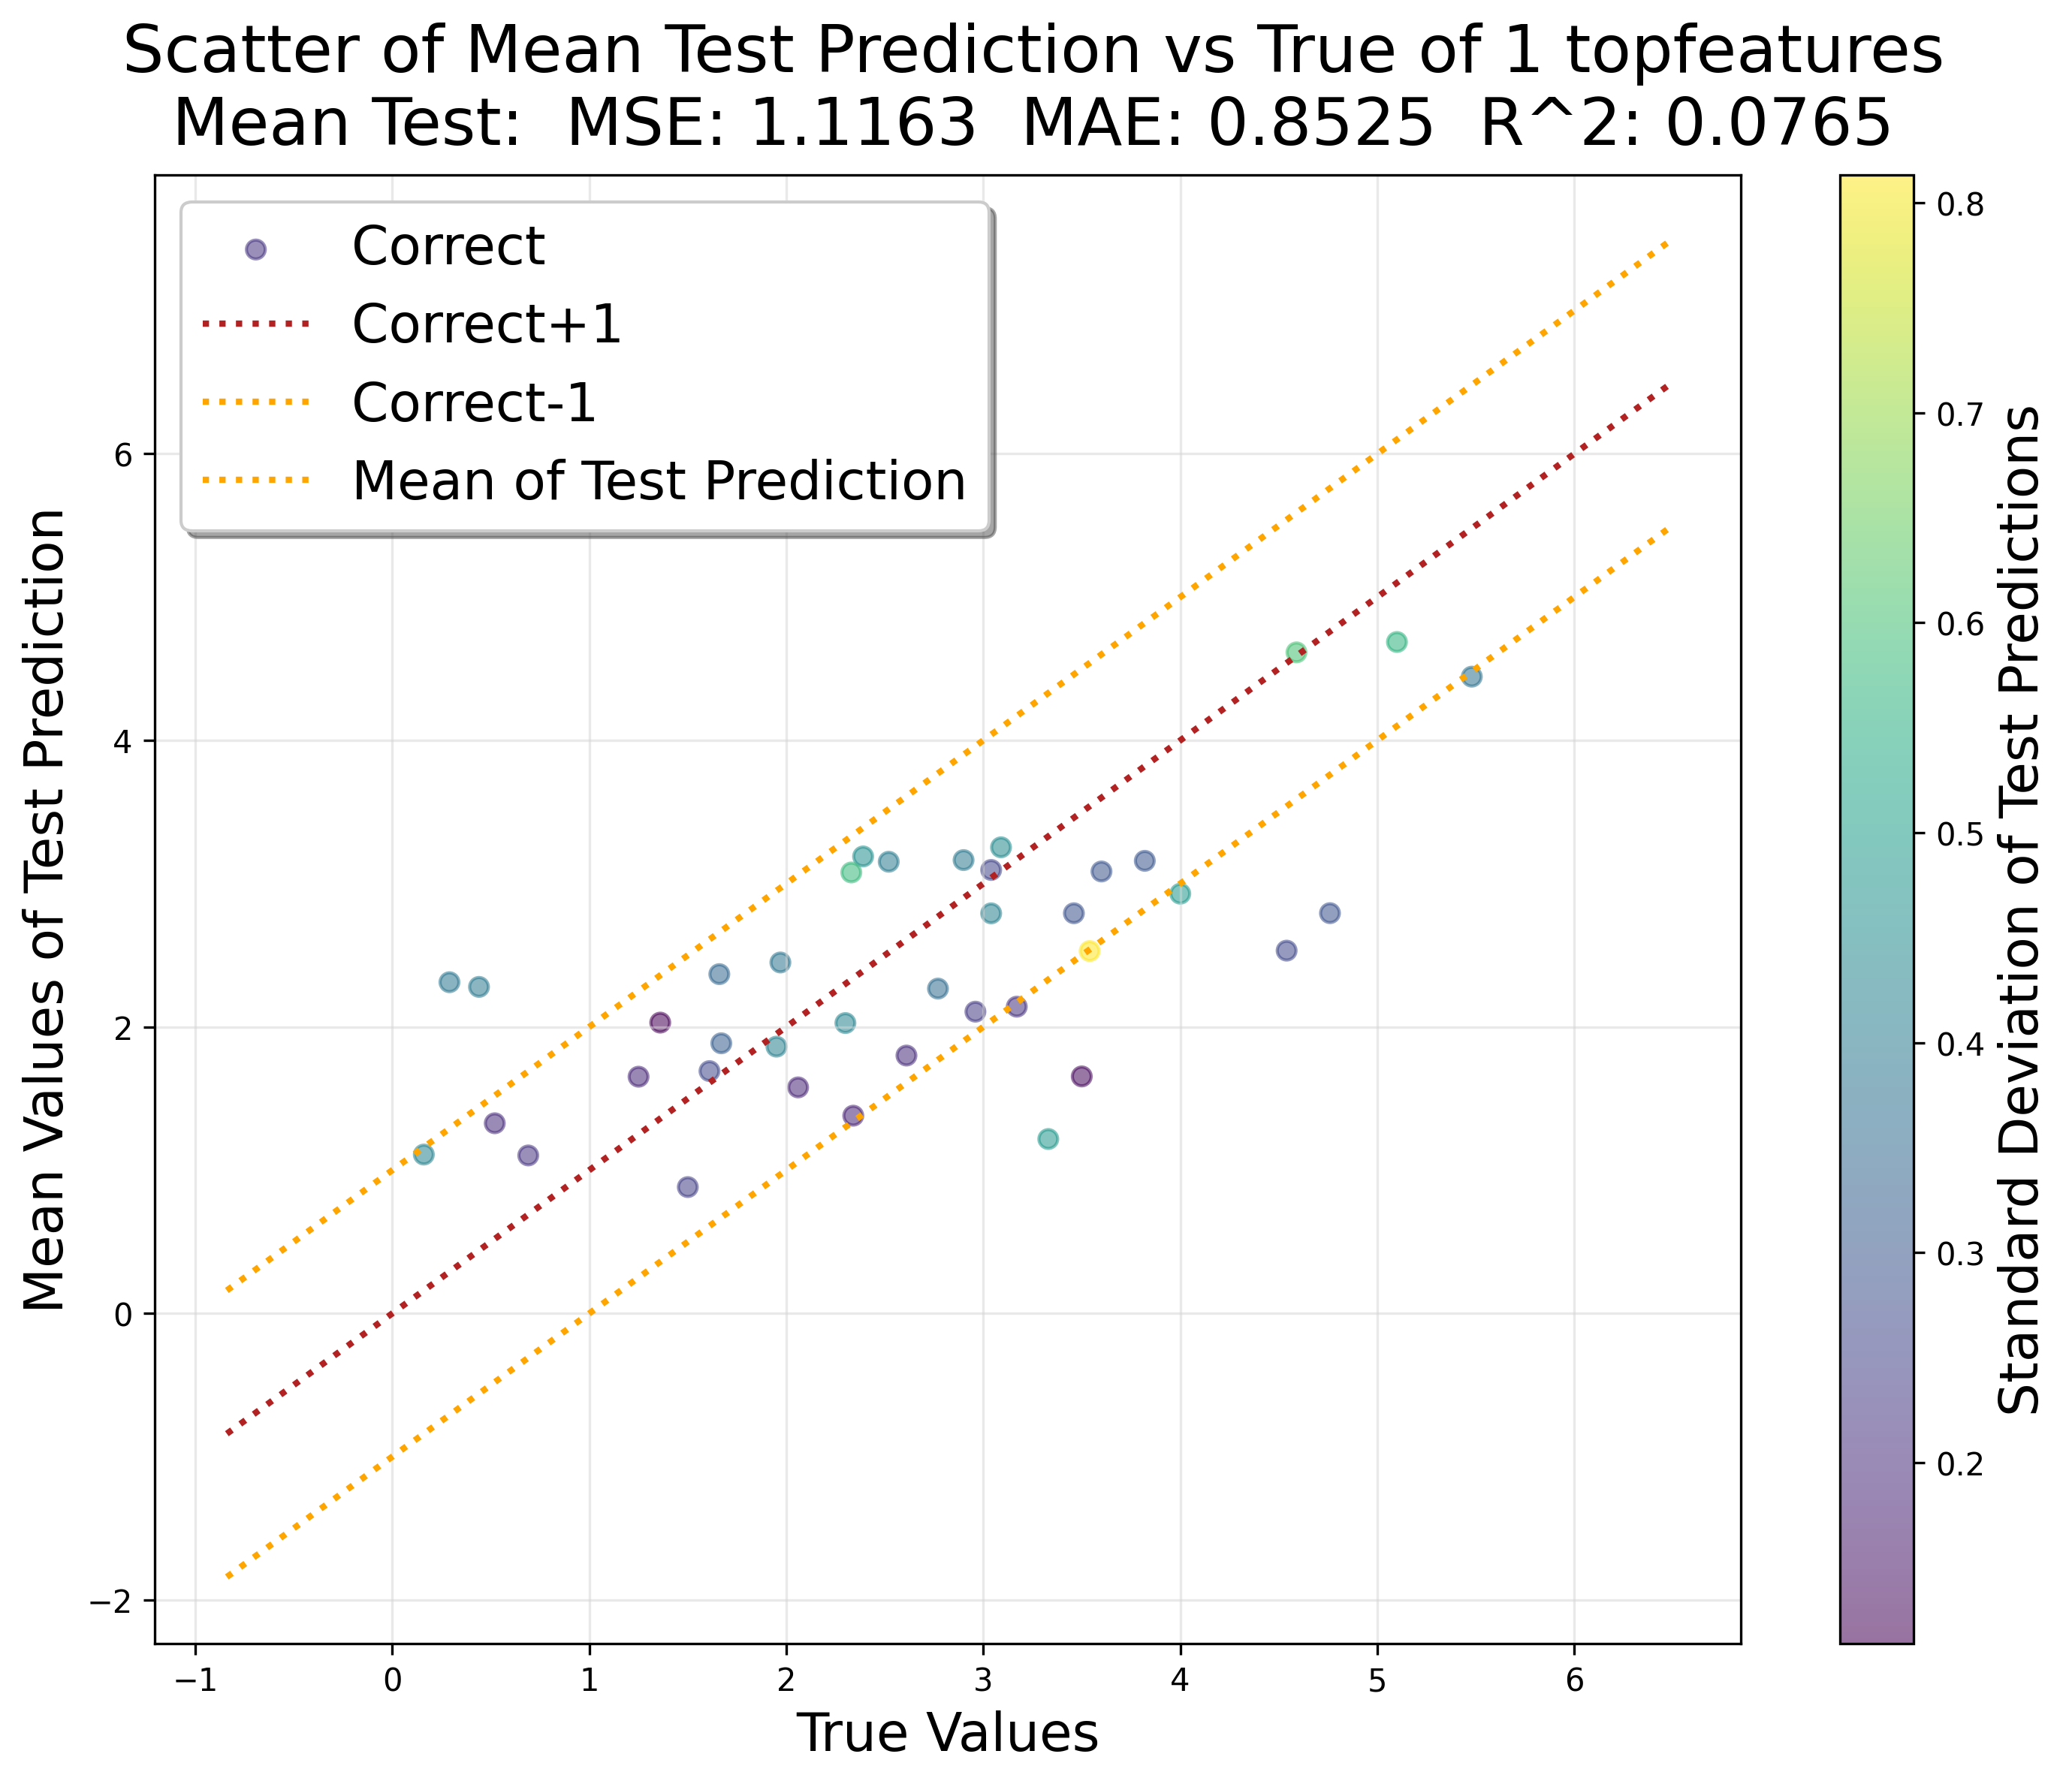

[49, 40]
2
Round 1 Begin:
   MSE: 0.86394   MAE: 0.76276   MSE: 0.81529    MSE: 0.51703  R^2: 0.19945    MSE: 0.44579   MSE: 0.87251    MSE: 0.93370   MAE: 0.57551
   MAE: 0.56961  MAE: 0.80806   MAE: 0.64868   MSE: 1.38806    MSE: 0.42185   R^2: -0.84544       MSE: 0.30208  R^2: 0.33713
  R^2: 0.43809  MAE: 0.77255   MSE: 0.28238   MSE: 0.87398  MAE: 1.00115  MAE: 0.52755
  R^2: 0.22536 
   
    MAE: 0.46901  MAE: 0.70700  R^2: 0.49939  MAE: 0.46745

  R^2: 0.75553   R^2: 0.44135     MSE: 0.39558  R^2: 0.62392
  R^2: 0.78946  R^2: 0.42571

 
  MAE: 0.56086   R^2: 0.25360
   MSE: 0.43012   MAE: 0.52734   R^2: 0.55961
   MSE: 0.22731   MSE: 0.91011    MAE: 0.39633  MAE: 0.90937   MSE: 0.52853     R^2: 0.35768  R^2: 0.59990  MAE: 0.65473

   R^2: 0.59780
   MSE: 0.67543   MAE: 0.58068   R^2: 0.69142
   MSE: 0.17122   MAE: 0.35973   R^2: 0.86121
   MSE: 0.65079    MSE: 0.83575  MAE: 0.68351   MSE: 0.68534    MSE: 0.36870   R^2: 0.69578   MAE: 0.78000
   MAE: 0.76091   MAE: 0.56233   R^2: 

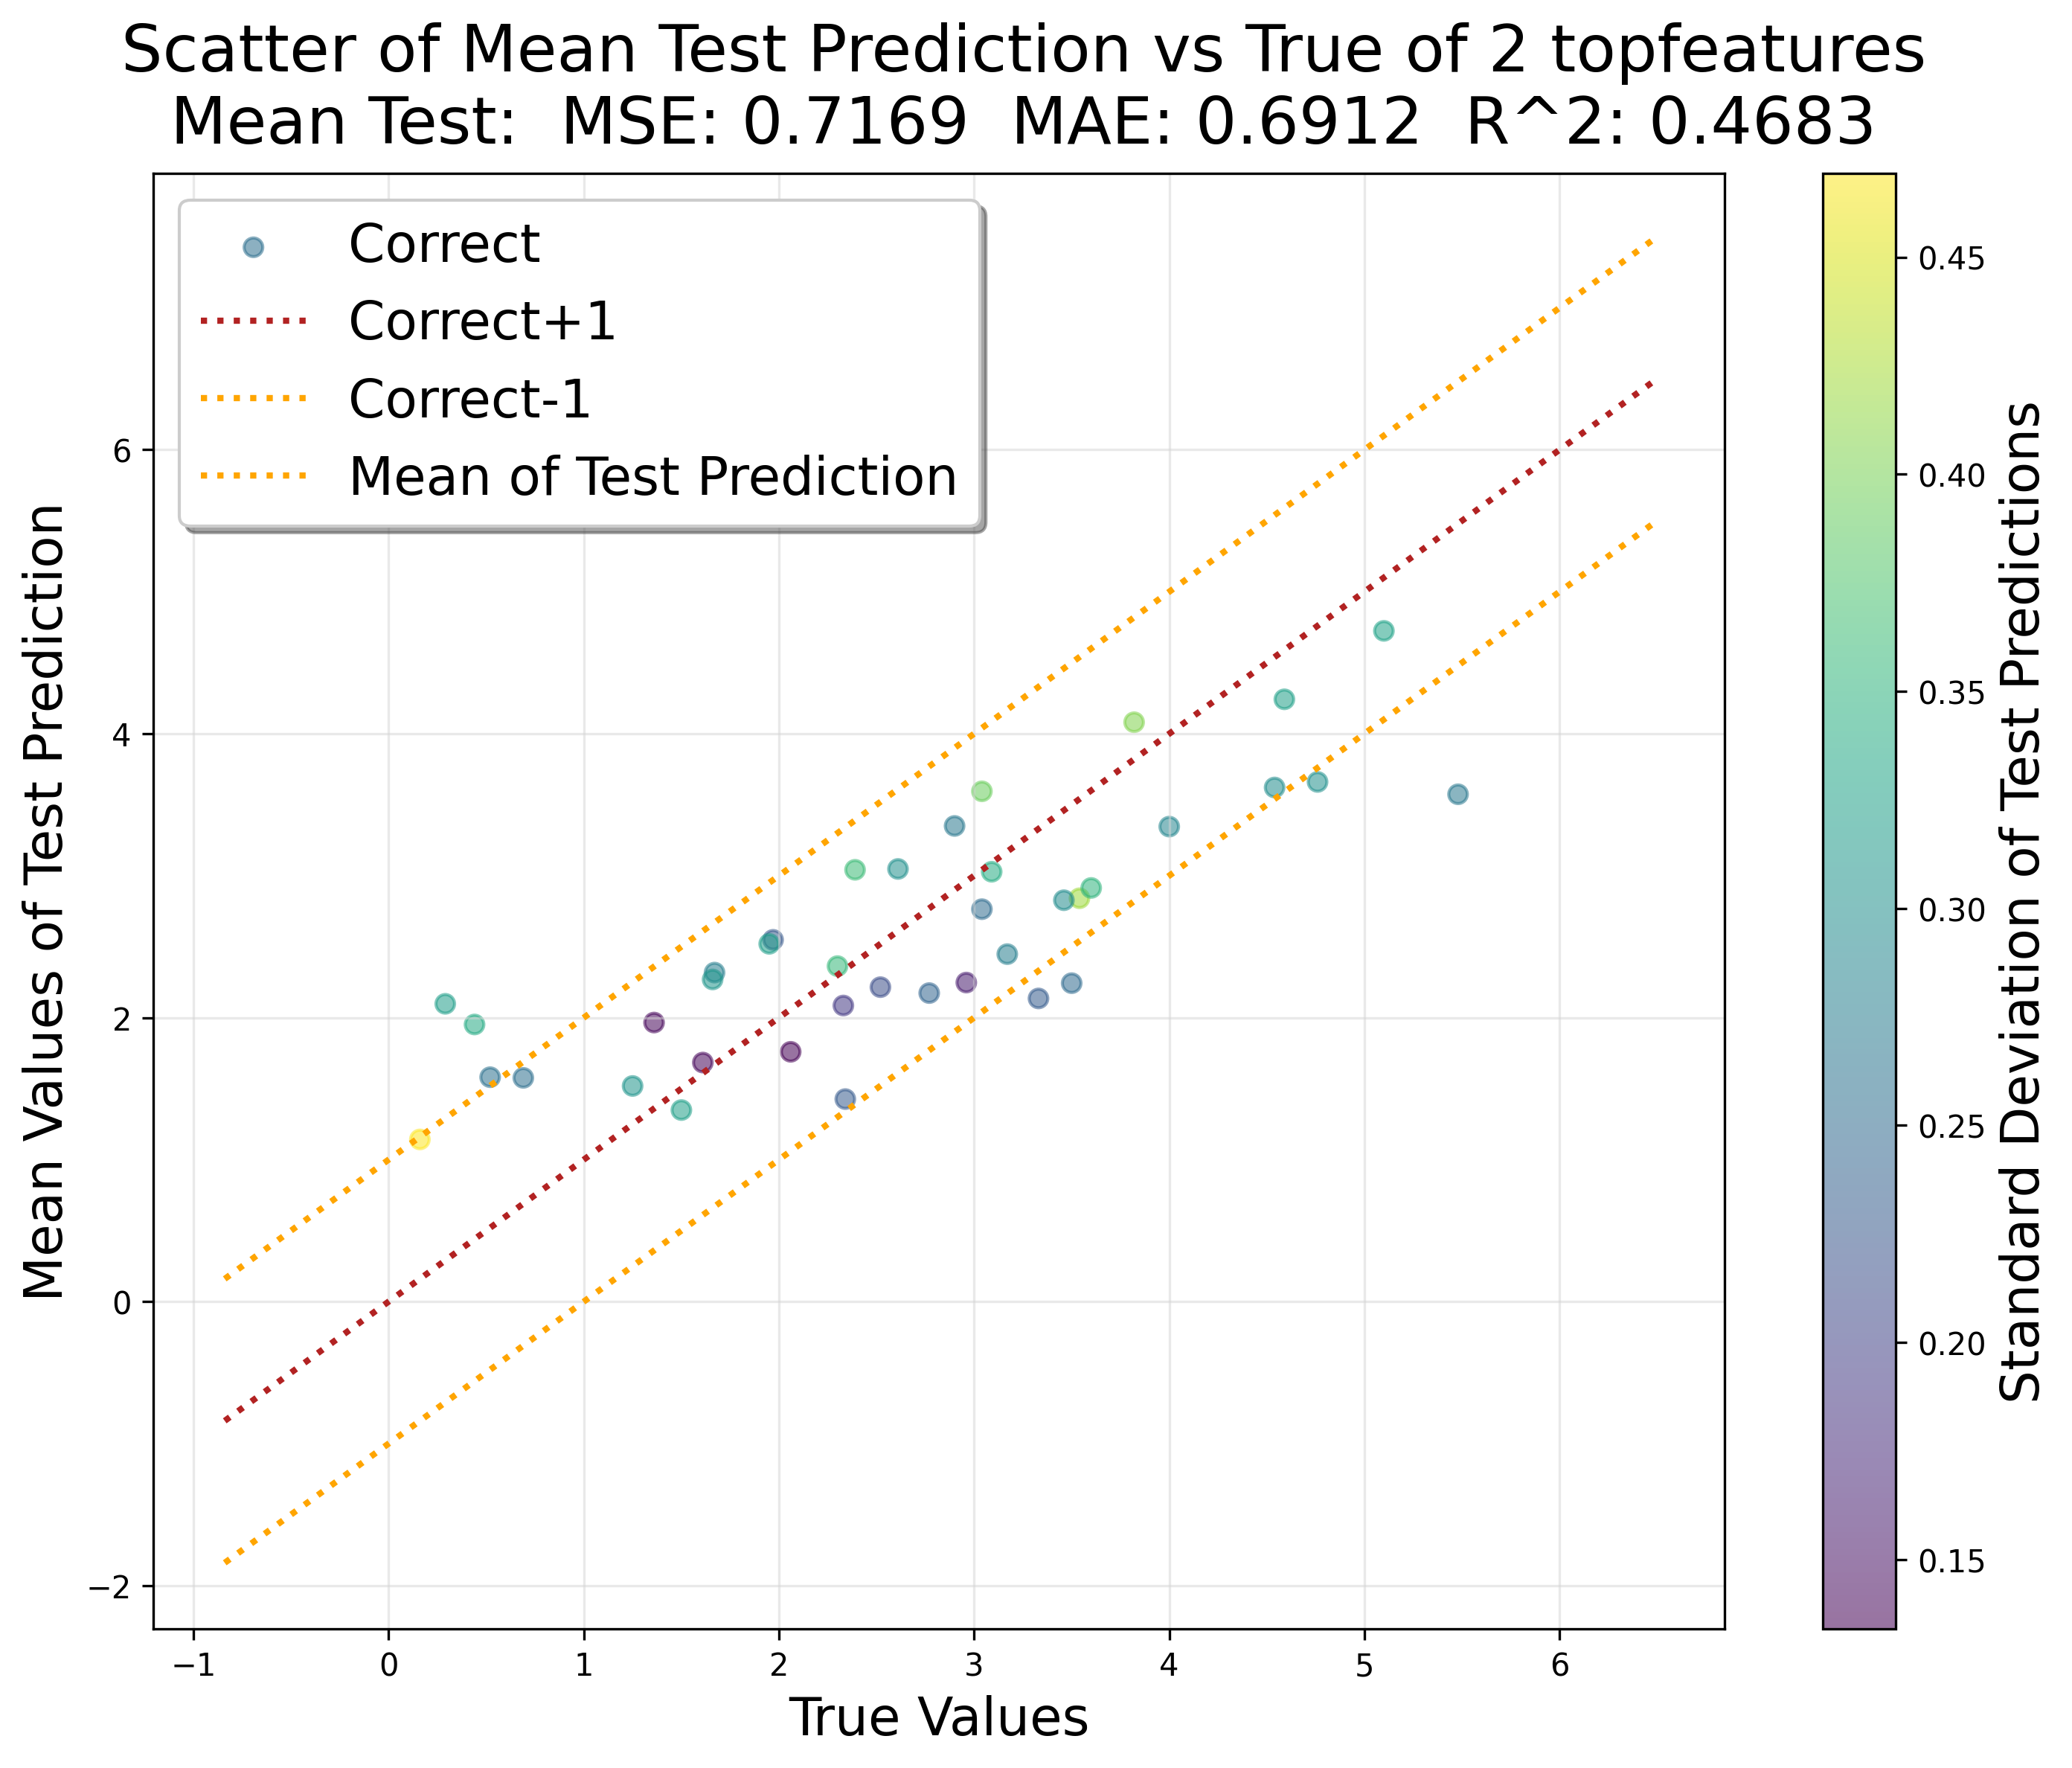

[49, 40, 33]
3
Round 1 Begin:
   MSE: 0.22902   MAE: 0.40225   MSE: 1.11752   R^2: 0.67515   MSE: 0.78195   MAE: 0.94736
    MAE: 0.82589  R^2: 0.18694    MSE: 0.14661
   R^2: 0.25247  MAE: 0.33823    MSE: 0.68692  R^2: 0.87371   MAE: 0.69230

    MSE: 0.22219  R^2: 0.63256   MSE: 0.31808    MSE: 0.52291
    MAE: 0.40738  MAE: 0.46315    R^2: 0.34385  MAE: 0.55228  R^2: 0.73597
 
   MSE: 0.43511  R^2: 0.65152    MSE: 0.28602
  MAE: 0.51058    MAE: 0.43344  R^2: 0.39494 
  R^2: 0.51139
   MSE: 0.17591   MAE: 0.40747   R^2: 0.69599
   MSE: 1.63080   MAE: 1.19705   R^2: 0.26105   MSE: 0.51733   MSE: 0.32773
    MAE: 0.57741  MAE: 0.40942    R^2: 0.25499  R^2: 0.75003

   MSE: 0.36972    MSE: 0.76109  MAE: 0.49977   MSE: 0.59301    R^2: 0.67405  MAE: 0.83010 
  MAE: 0.67254   R^2: 0.70480   R^2: 0.64736

   MSE: 1.05707   MAE: 0.76018   R^2: 0.42288   MSE: 0.39309
   MSE: 0.74959   MAE: 0.50993    MAE: 0.65159   R^2: 0.48491  R^2: 0.60906

   MSE: 1.00201   MSE: 0.71980    MAE: 0.73169  MA

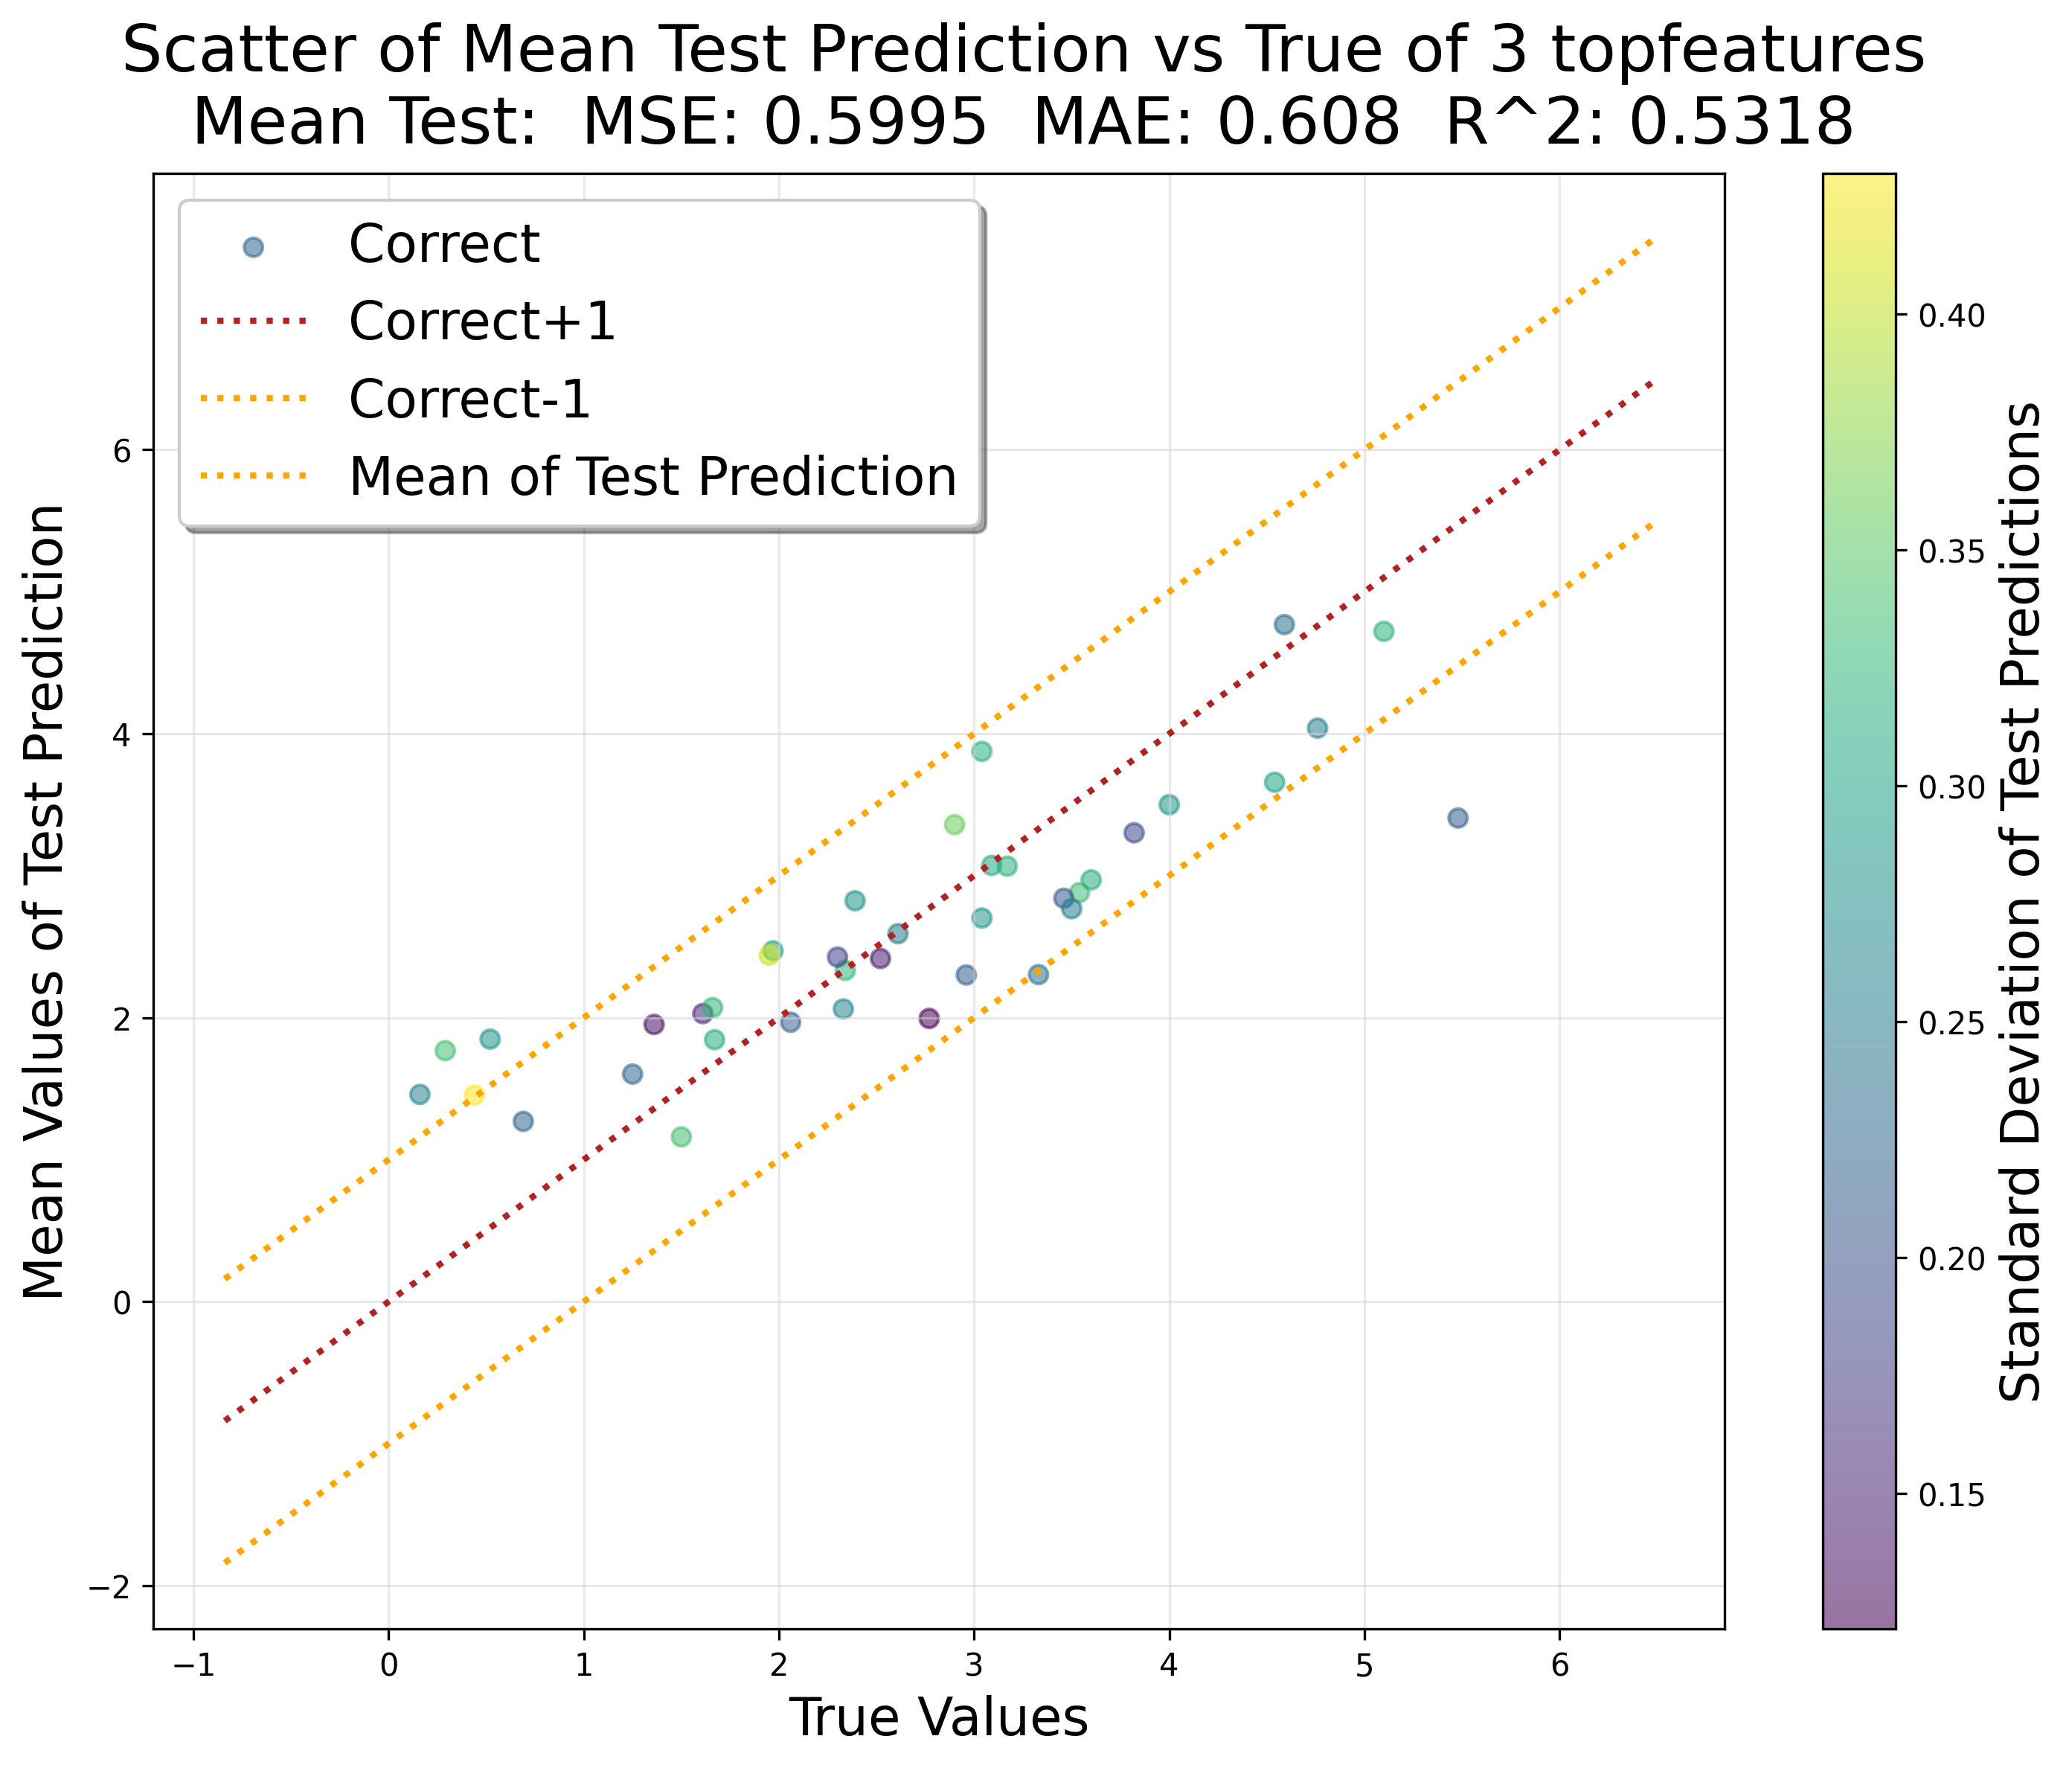

[49, 40, 33, 23]
4
Round 1 Begin:
   MSE: 0.26405    MSE: 0.83606   MSE: 0.50486   MSE: 1.03082  MAE: 0.42814     MAE: 0.76657    MSE: 1.12975  MAE: 0.64591     R^2: 0.62974   MSE: 2.25394  MAE: 0.81216  R^2: 0.69508  R^2: 0.15131

  MAE: 0.88981
   MSE: 0.83556     R^2: 0.50354
    MSE: 0.78994  MAE: 1.19708  MAE: 0.68434  R^2: 0.33272   R^2: 0.06087
 
    MSE: 0.55486   MSE: 0.32549  R^2: 0.05019  MAE: 0.69233    MAE: 0.63974
   R^2: 0.68484   R^2: 0.64047  MAE: 0.51105    MSE: 0.53209
  R^2: 0.75454   MSE: 1.00550   MSE: 0.33479    MSE: 0.79440    MSE: 0.23275   MSE: 0.28695  MAE: 0.92057
 
   MSE: 0.56786     MAE: 0.64365     MSE: 0.30077  MAE: 0.68191  R^2: 0.33385  MAE: 0.39115  MAE: 0.44303    MSE: 0.20274   MSE: 0.20168  MAE: 0.67993    MAE: 0.48416      MSE: 0.74827   MSE: 0.38927   MSE: 0.58249  MAE: 0.43765   MSE: 0.55078 
  R^2: 0.40179  MAE: 0.29591   R^2: 0.49404    R^2: 0.84896       MSE: 1.31909  R^2: 0.71344
   MSE: 0.63526   MAE: 0.61102  MAE: 0.54035  R^2: -0.18227  

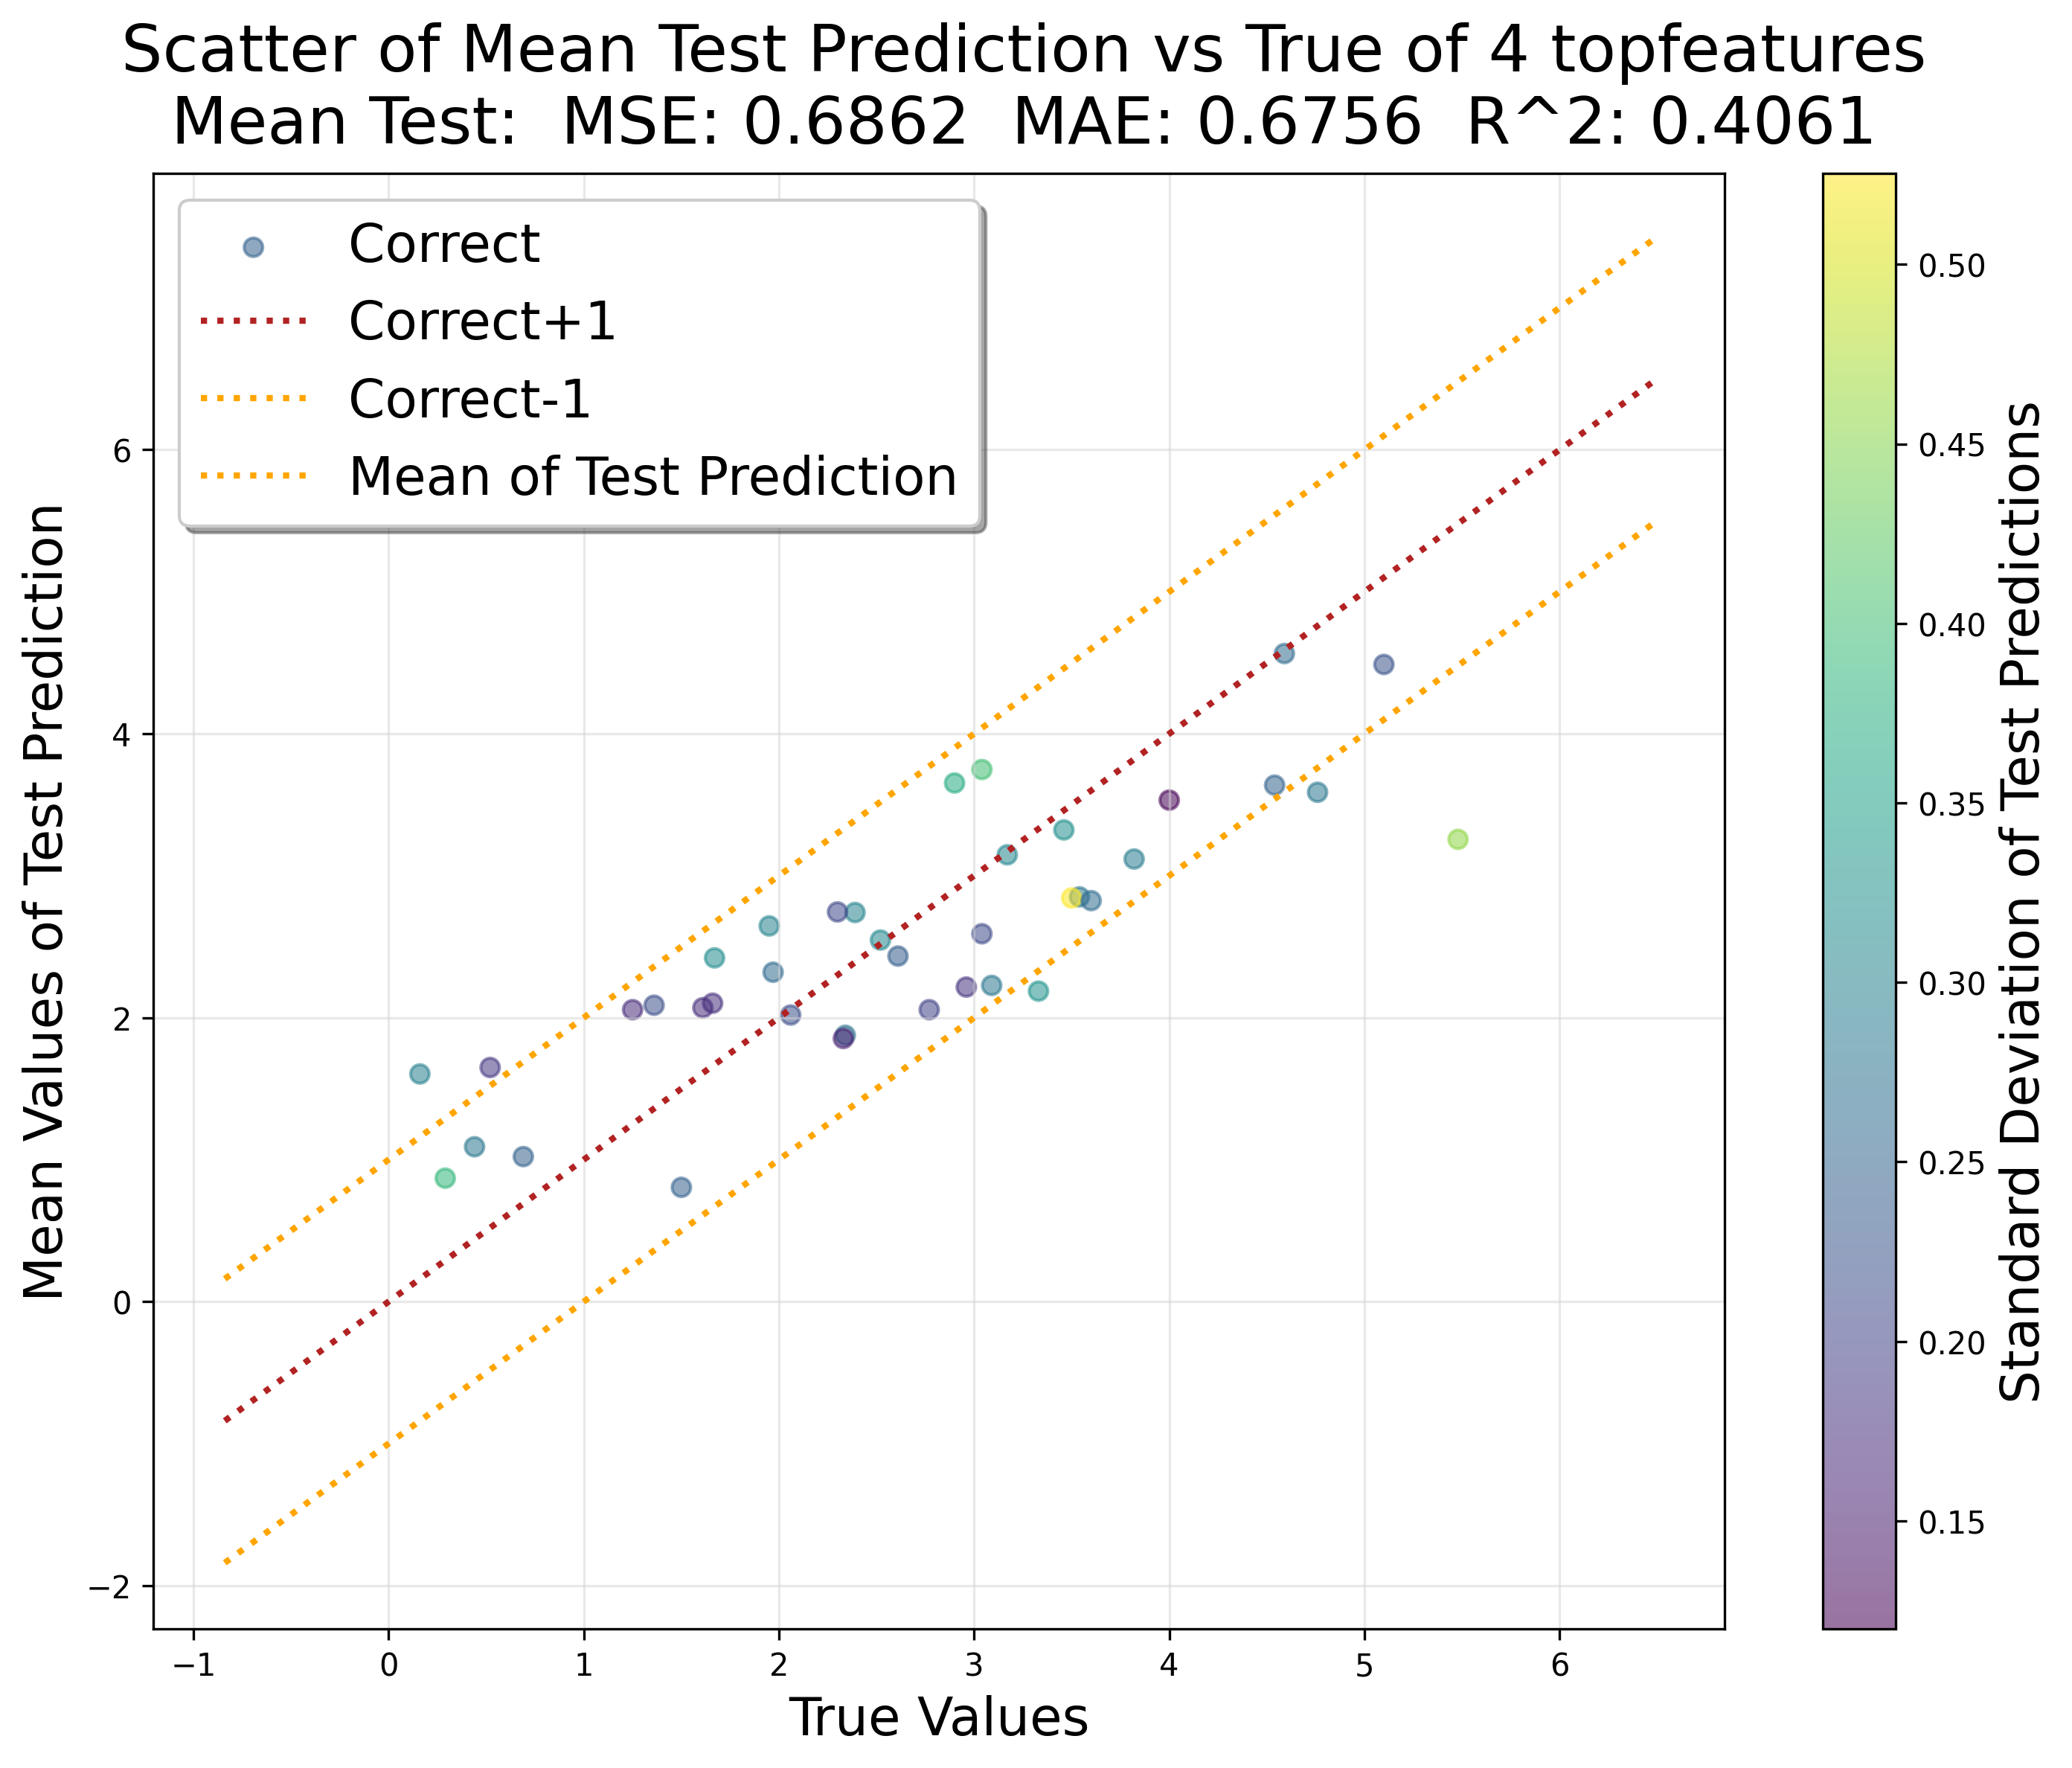

[49, 40, 33, 23, 50]
5
Round 1 Begin:
   MSE: 0.25795   MAE: 0.47356    MSE: 0.94683  R^2: 0.70608
   MAE: 0.86472   R^2: 0.13822
   MSE: 0.37725    MSE: 2.82811   MSE: 0.26231    MAE: 1.32416  MAE: 0.40959  MAE: 0.52711    R^2: 0.68691  R^2: -0.49877

   MSE: 0.90375   MSE: 0.50791     MSE: 0.42763   R^2: 0.68042  MAE: 0.90614  MAE: 0.68635
     R^2: -0.16081  R^2: 0.27589  MAE: 0.54757

   R^2: 0.53942   MSE: 0.68124   MSE: 0.85656
    MAE: 0.85818  MAE: 0.73521    R^2: 0.69967  R^2: 0.75266

   MSE: 0.81227   MSE: 0.21952    MAE: 0.86110   MAE: 0.42626  R^2: 0.22764 
  R^2: 0.34258
   MSE: 0.32693   MAE: 0.43786   R^2: 0.83046
   MSE: 0.45040   MAE: 0.58860    MSE: 0.51193  R^2: 0.20363
   MAE: 0.65143   R^2: -0.23264
   MSE: 0.52377   MAE: 0.68923   R^2: 0.60808
   MSE: 0.61576   MSE: 0.32290    MAE: 0.75036   MSE: 0.54326  MAE: 0.50665    R^2: 0.69458   R^2: 0.84197
  MAE: 0.66559
   R^2: 0.67604
   MSE: 0.32102   MAE: 0.53646    MSE: 0.39772  R^2: 0.75141
   MAE: 0.51706   R^2: 0

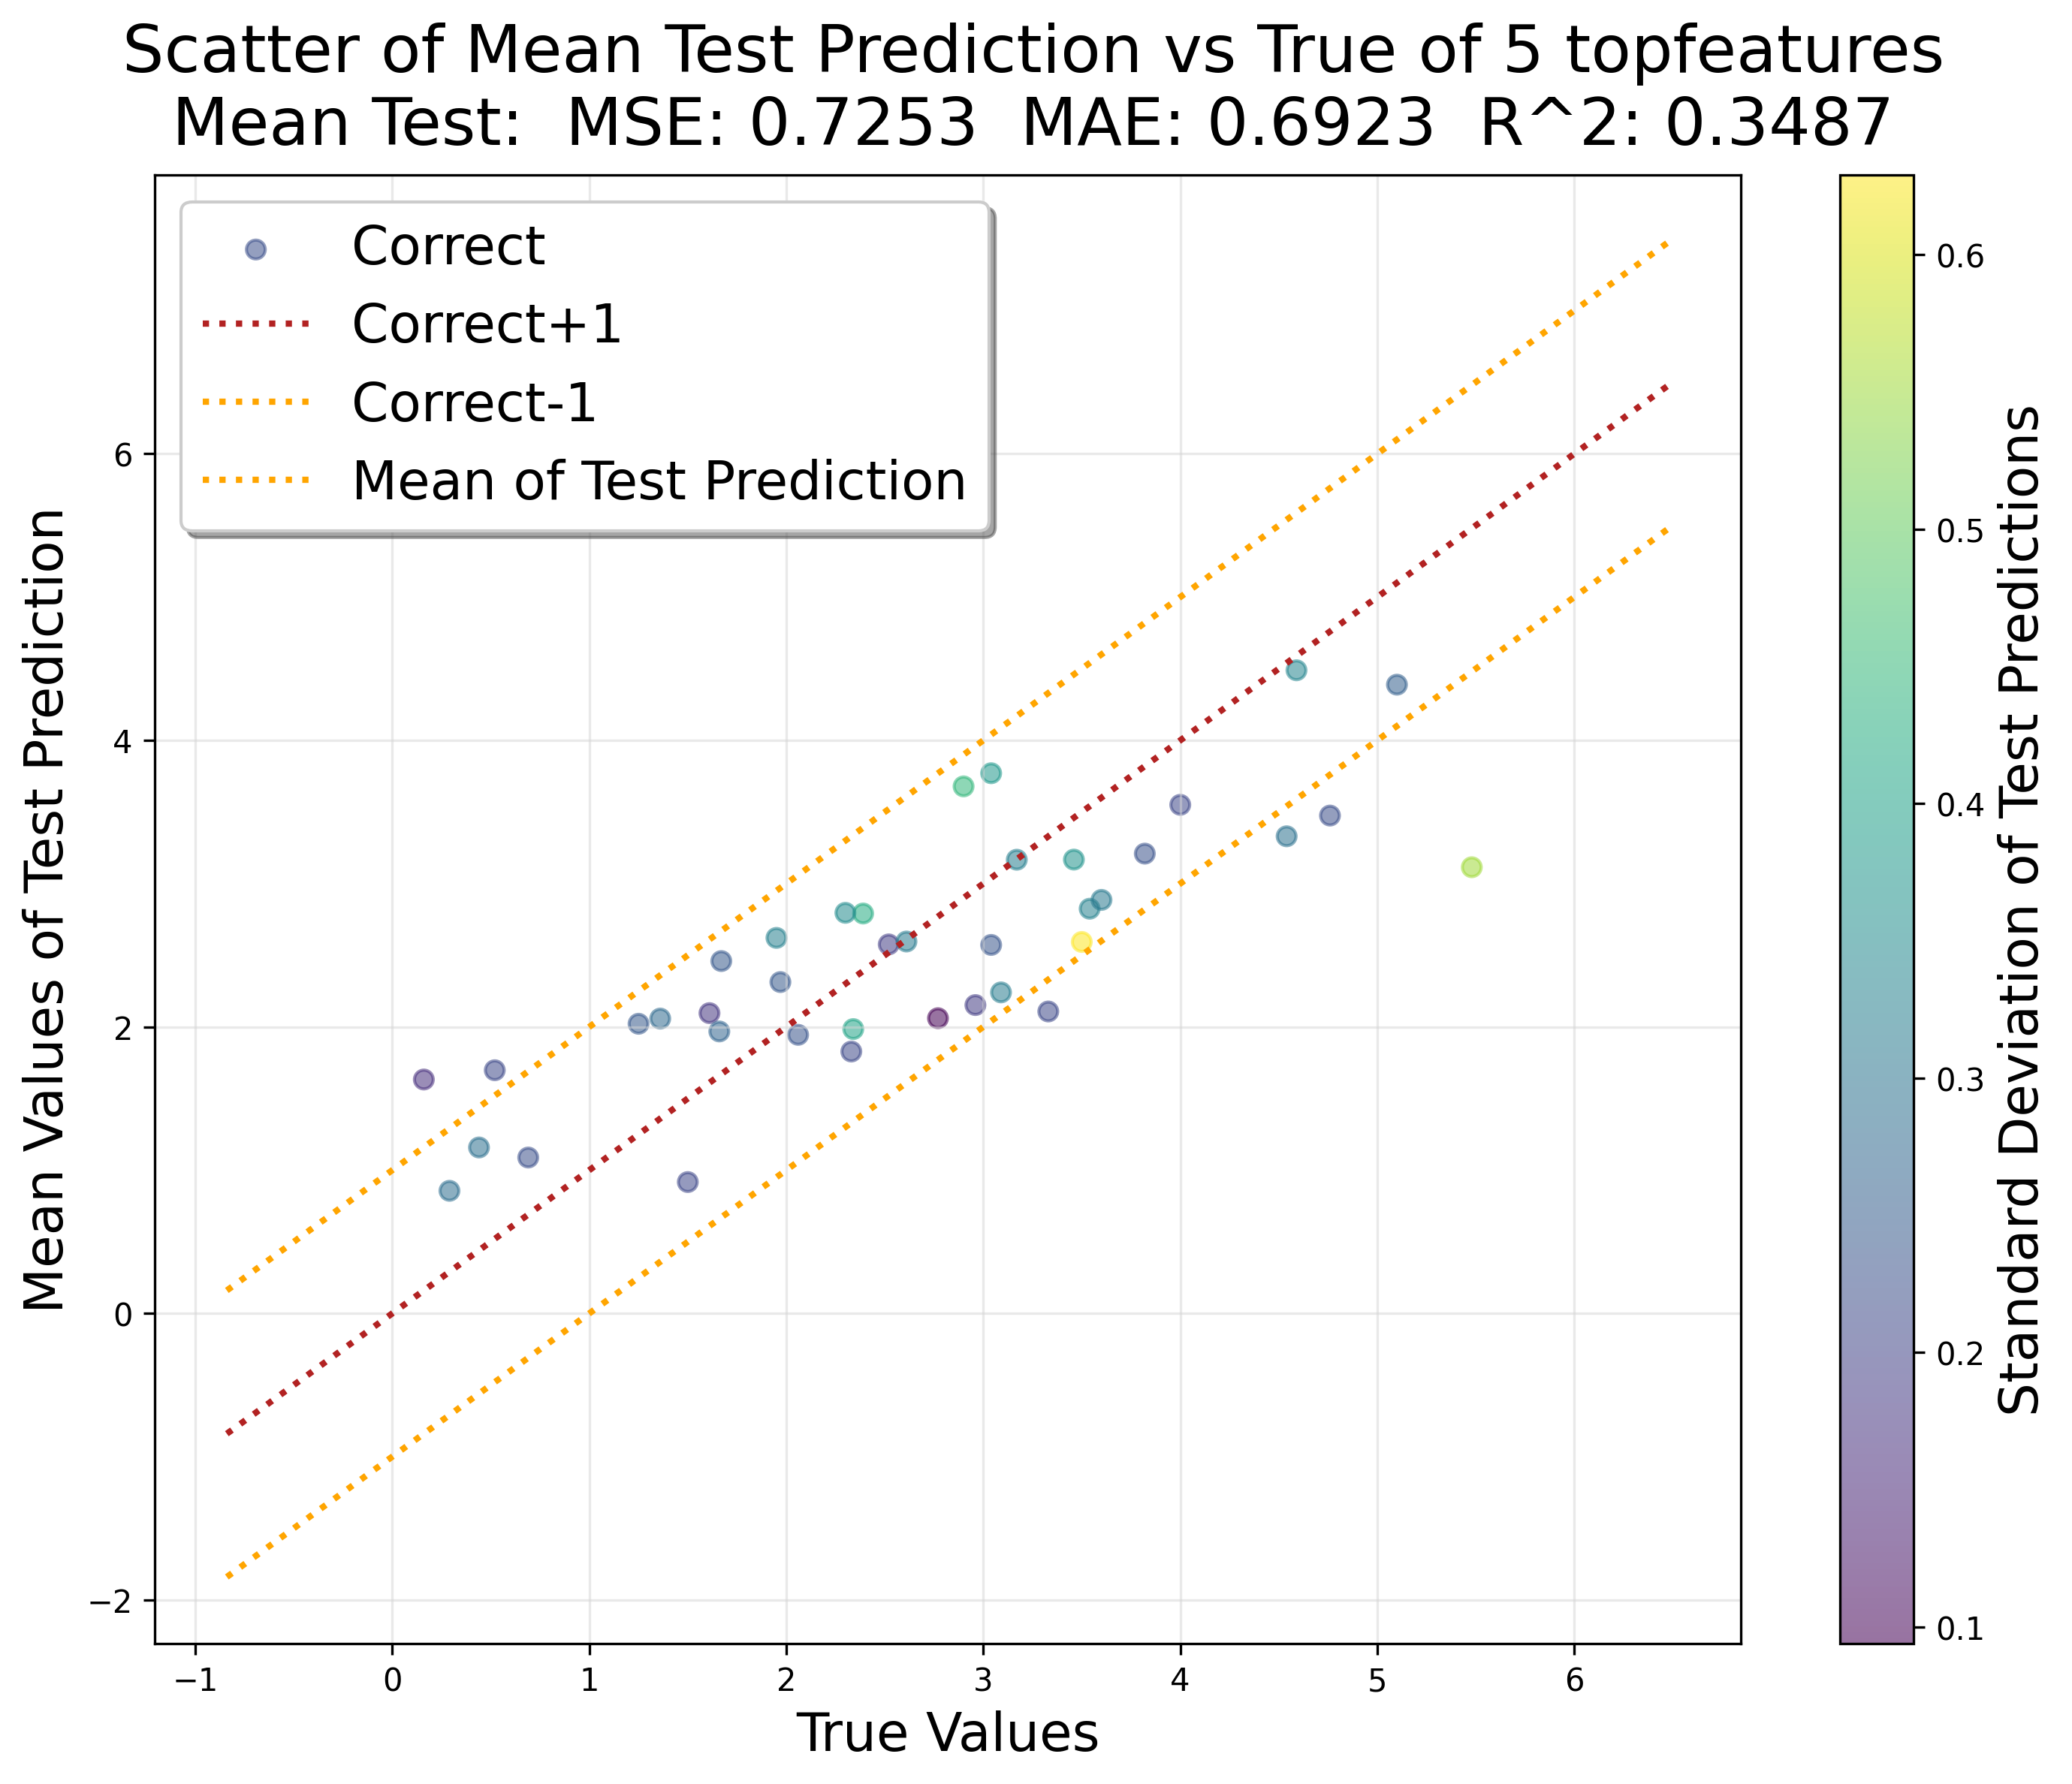

In [17]:
X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
X_train = X[~test_mask]
y_train = y[~test_mask]
Xrealtest = X[test_mask]
yrealtest = y[test_mask]
X=X_train
y=y_train
print('X:', X.shape, '   y:', y.shape)
besttitle =title[bestfeatlist]
thistitleindex=[]
titlelist=[]
mselist=[]
Xtemp=[]
y_realtest_pred_list=[[]]

for jj in range(len(besttitle)):#len(title)-1
    
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
    Xrealtesttemp=Xrealtest[:,titlelist]
    print(len(Xtemp[0]))
        
    perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras,Xrealtesttemp)
    y_realtest_pred=perf[7]
    y_realtest_pred_reshaped = y_realtest_pred.reshape(1, -1)
    append_filename = Path('.', DIR, 'All_Realtestpred_' + c_time + '.txt')
    with open(append_filename, 'a+') as f:
        np.savetxt(f, y_realtest_pred_reshaped, fmt='%s', delimiter=',')
    
    
    y_realtest_pred_std=perf[8]
    y_realtest_pred_reshaped_std = y_realtest_pred_std.reshape(1, -1)
    append_filename = Path('.', DIR, 'All_Realtestpredstd_' + c_time + '.txt')
    with open(append_filename, 'a+') as f:
        np.savetxt(f, y_realtest_pred_reshaped_std, fmt='%s', delimiter=',')
    
        
    full_m=perf[3]
    full_m = np.array(full_m)
    test_idx_m = perf[4]
    test_idx_m = np.array(test_idx_m)
    save_name = 'XGBoost_02a_Test_Index_'+str(len(Xtemp[0]))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, test_idx_m, fmt='%d', delimiter=',')
    shap_m=perf[6]
    save_name = 'SHAP_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_name = Path('.', DIR, save_name)
    np.savetxt(save_name, shap_m, fmt='%s', delimiter=',')
    save_nameX = 'Feature_Matrix_'+str(len(titlelist))+'_'+c_time+'.csv'
    save_nameX = Path('.', DIR, save_nameX)
    np.savetxt(save_nameX, Xtemp, fmt='%s', delimiter=',')
    test_data_m = []
    for i in range(X.shape[0]):
        test_data_m.append([])
    for i in range(test_idx_m.shape[0]):
        for j in range(test_idx_m.shape[1]):
            test_data_m[test_idx_m[i, j]].append(full_m[i, test_idx_m[i, j]])
    test_upper_l = []
    test_lower_l = []
    test_mean_l = []
    test_median_l = []
    test_std_l = []
    for i in range(X.shape[0]):
        test_upper_l.append(max(test_data_m[i]))
        test_lower_l.append(min(test_data_m[i]))
        test_mean_l.append(np.mean(test_data_m[i]))
        test_median_l.append(np.median(test_data_m[i]))
        test_std_l.append(np.std(test_data_m[i]))
        
    true_y = y.flatten().tolist()
    fig = plt.figure(figsize=(10, 8), dpi=300)
    ax = fig.add_axes([0.11, 0.08, 0.88, 0.815])
    sc = ax.scatter(true_y, test_mean_l, alpha=0.55, c=test_std_l, cmap='viridis', marker='o')
    left_limit = min(min(true_y)-1, min(test_mean_l)-1)
    right_limit = max(max(true_y)+1, max(test_mean_l)+1)
    ax.plot([left_limit, right_limit], [left_limit, right_limit], color='#B22222', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit+1, right_limit+1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.plot([left_limit, right_limit], [left_limit-1, right_limit-1], color='#FFA500', linestyle=':', linewidth = '2')
    ax.legend(['Correct', 'Correct+1', 'Correct-1', 'Mean of Test Prediction'], loc='upper left', fontsize=17, shadow=True)
    ax.set_xlabel('True Values', fontsize=17)
    ax.set_ylabel('Mean Values of Test Prediction', fontsize=17)
    plt.suptitle('Scatter of Mean Test Prediction vs True of '+str(len(Xtemp[0]))+' topfeatures\n'+
                 'Mean Test:  MSE: '+str(round(perf[0], 4))+
                 '  MAE: '+str(round(perf[1], 4))+
                 '  R^2: '+str(round(perf[2], 4)), fontsize=21)
    cb = plt.colorbar(sc)
    cb.set_label('Standard Deviation of Test Predictions', fontsize=17)
    plt.grid(which='major', color='#D5D5D5', alpha=0.5)
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()
    mselist.append(round(perf[0],3))
    xgbscatterdata= np.column_stack((true_y, test_mean_l, test_std_l))
    save_name1 = 'XGBoost_02c_Mean_Test_Prediction_Distribution_'+str(len(Xtemp[0]))+'_topfeatures'+'_MSE'+str(round(perf[0],3))+'_MSEstd'+str(round(perf[5],3))+'_MAE'+str(round(perf[1],3))+'_R^sq'+str(round(perf[2],3))+besttitle[jj]+'.txt'
    save_name2 = Path('.', DIR, save_name1)
    with open(save_name2,"w") as f:
        np.savetxt(save_name2,xgbscatterdata, fmt='%s', delimiter=',', comments='!')
    f.close()


In [18]:
len(Xtemp)

39

[1.116, 0.717, 0.6, 0.686, 0.725]
2
['Asymmetry_Ratio' 'N27aliemin' 'N27espmax' 'N4espmin'
 'Total_number_of_peaks']
[49]
[49, 40]
[49, 40, 33]
[49, 40, 33, 23]
[49, 40, 33, 23, 50]


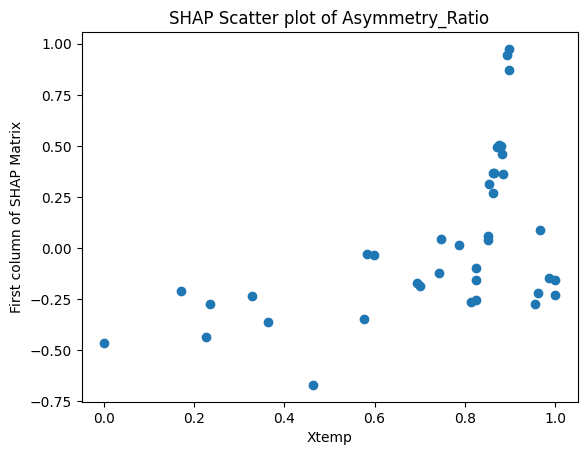

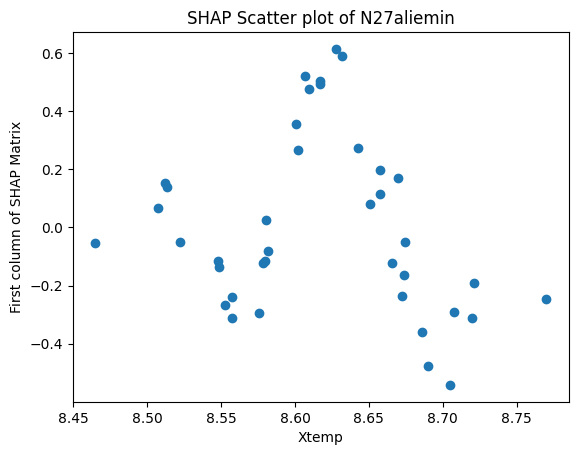

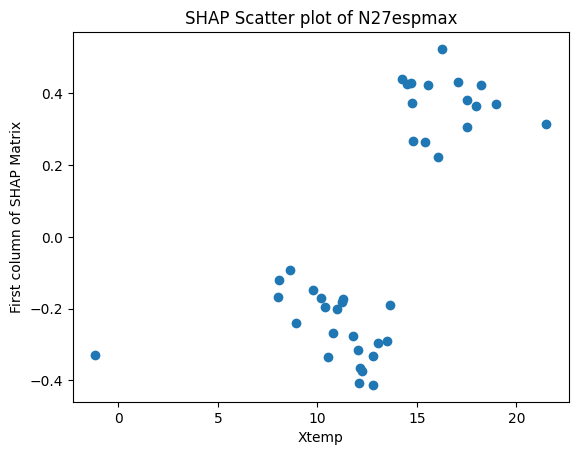

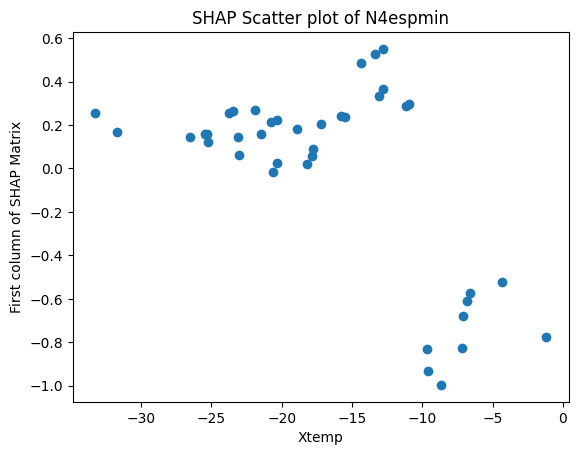

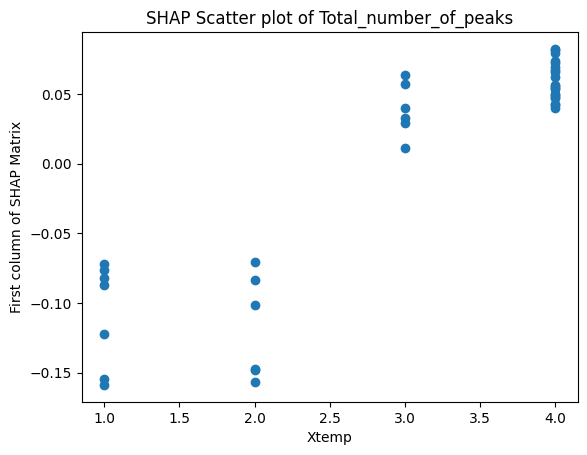

In [19]:
print(mselist)
print(mselist.index(min(mselist)))
print(title[bestfeatlist])
titlelist=[]
Xtemp=[]
for jj in range(len(bestfeatlist)):#len(title)-1
    thistitleindex=np.where(title==besttitle[jj])
    titlelist.append(thistitleindex[0][0])
    print(titlelist)
    Xtemp=X[:,titlelist]
# Create a scatter plot
for jj in range(len(bestfeatlist)):#len(title)-1
    plt.scatter(Xtemp[:,jj], shap_m[:, jj])
    plt.xlabel('Xtemp')
    plt.ylabel('First column of SHAP Matrix')
    plt.title('SHAP Scatter plot of '+title[titlelist[jj]])
    save_name = 'XGBoost_02b_Mean_Test_Prediction_Distribution_'+str(title[titlelist[jj]])+'_'+c_time+'.png'
    save_name = Path('.', DIR, save_name)
    plt.savefig(save_name)
    plt.show()

In [20]:
# 全特征的预测
point = round(X.shape[0]*TRAIN_TEST_SPLIT)
# featnum=mselist.index(min(mselist))
permutation = np.random.permutation(y.shape[0])
train_idx = permutation[:point]
test_idx = permutation[point:]
X_train = X[train_idx, :]
y_train = y[train_idx]
X_test = X[test_idx, :]
y_test = y[test_idx]

# 初始化XGBRegressor对象

clf = XGBRegressor(n_estimators=350, learning_rate=0.03, max_depth=8, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-3), reg_lambda=np.exp(-3), gamma=np.exp(-5), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
# 设置模型的超参数
for k, v in paras.items():
    clf.set_params(**{k: v})
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
# 计算在测试集上的预测值
y_pred = clf.predict(Xrealtest)
print(y_pred)
# titlelist=[]
# Xtemp=[]
# thistitleindex=[]
# Xrealtesttemp=[]
# for jj in range(len(besttitle)):#len(title)-1
#     thistitleindex=np.where(title==besttitle[jj])
#     titlelist.append(thistitleindex[0][0])
# #     print(titlelist)
#     Xtemp=X[:,titlelist]
#     Xrealtesttemp=Xrealtest[:,titlelist]
# clf.fit(Xtemp, y)
# # 计算损失
# y_pred2 = clf.predict(Xrealtesttemp)
# print(y_pred2)
save_name1 = 'XGBpred_Full'+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,[y_pred,y_realtest_pred_reshaped[-1]], fmt='%s', delimiter=',', comments='!')


[1.2032366 2.0596337 2.9362237 2.2347097]


In [21]:
mae = mean_absolute_error(yrealtest, y_realtest_pred_reshaped[-1])
mae

0.5121197342872621

In [22]:
len(X)

39